Create an engine to the "census" MySQL database 

In [84]:
from sqlalchemy import create_engine, URL, Table, MetaData, func, asc, desc
from sqlalchemy import text

    
engine = create_engine("mysql+mysqldb://root:<password>localhost/census_db")
# Get a Connection object
conn = engine.connect()

Create an engine to the "census" PostgreSQL database 

In [31]:
from sqlalchemy import create_engine, URL
from sqlalchemy import text
from sqlalchemy import inspect


# Create an Engine object
url_object = URL.create(
    "postgresql+psycopg2",
    username="postgres",
    password="<password>",  # plain (unescaped) text
    host="localhost",
    database="census_db",
    port=5434
)

engine = create_engine(url_object)
# Get a Connection object
conn = engine.connect()
# Use the Connection object to execute a query
result = conn.execute(text("SELECT * FROM census_db.census")).fetchall()

print (inspect(engine).get_schema_names())
inspector =  inspect(engine)
schemas = inspect(engine).get_schema_names()
for schema in schemas:
    print("schema: %s" % schema)
    for table_name in inspector.get_table_names(schema=schema):
        print(table_name)



['census_db', 'information_schema', 'public']
schema: census_db
census
state_fact
schema: information_schema
sql_parts
sql_languages
sql_features
sql_implementation_info
sql_packages
sql_sizing
sql_sizing_profiles
schema: public


Calculate the change in population from 2000 to 2008. Find the top 5 states by population growth.

In [92]:
r = conn.execute(text("SELECT state, SUM(pop2008 - pop2000) as d "
                      "FROM census_db.census "
                      "GROUP BY state "
                      "ORDER BY d DESC "
                      "LIMIT 5")).fetchall()

print(r)
top_5_states = []
for x in r:
    top_5_states.append(x[0])

[('Texas', Decimal('3383317')), ('California', Decimal('2779560')), ('Florida', Decimal('2281569')), ('Georgia', Decimal('1460732')), ('Arizona', Decimal('1336836'))]


Plot the trend of women population growth in the top 5 states from 2000 to 2008?

state,Florida,Arizona,California,Georgia,Texas
sum(pop2000),8206101,2583468,17033913,4171817,10522834
sum(pop2008),9312598,3240456,18350533,4911696,12162720


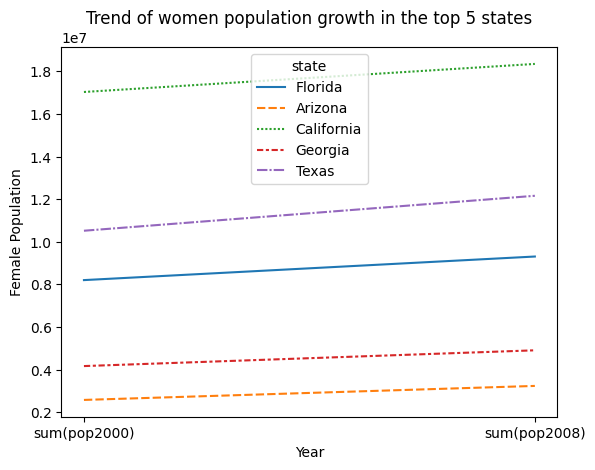

In [60]:
import numpy as np
import seaborn as sb
import pandas as pd


# execute the SQL statement with the named parameter
query = text("SELECT state, sex, sum(pop2000), sum(pop2008) "
                       "FROM census_db.census "
                       "WHERE sex = 'F' AND state IN :state_array "
                       "GROUP BY state, sex ")

r2 = conn.execute(query, {'state_array': top_5_states}).fetchall()

result_df = pd.DataFrame(r2)
plot = result_df.transpose()
plot.columns = plot.iloc[0]
plot = plot[2:]
plot = plot.rename(index={'pop2000':'2000', 'pop2008':'2008'})
display(plot)
p = sb.lineplot(data=plot)
p.set(xlabel='Year', ylabel='Female Population', title='Trend of women population growth');


Join the census and state_fact tables, compute the total population in 2008 for each state. Save and display the state name (ordered alphabetically), census division name, and total population in 2008 as the result set.

In [76]:
query = select(census.columns.state,
state_fact.columns.census_division_name,
func.sum(census.columns.pop2008).label("2008_population")).join(state_fact, census.columns.state == state_fact.columns.name)
query = query.group_by(census.columns.state, state_fact.columns.census_division_name)

query = query.order_by(asc('state'))
ResultSet = conn.execute(query).fetchall()
result = pd.DataFrame(ResultSet)
display(result)


,state,census_division_name,2008_population
0,Alabama,East South Central,4649367
1,Alaska,Pacific,664546
2,Arizona,Mountain,6480767
3,Arkansas,West South Central,2848432
4,California,Pacific,36609002
5,Colorado,Mountain,4912947
6,Connecticut,New England,3493783
7,Delaware,South Atlantic,869221
8,Florida,South Atlantic,18257662
9,Georgia,South Atlantic,9622508


Read small chunks of large dataset to count the number of records for each state, and save this result as a key-value store.

In [87]:
q = select(census.columns.state, func.count(census.columns.state))
q = q.group_by(census.columns.state)

ResultProxy = conn.execute(q)
ls = []
while l := ResultProxy.fetchmany(20):
    ls += list(l)
result_key_value_store = dict(ls)

display(result_key_value_store)

{'Illinois': 172,
 'New Jersey': 172,
 'District of Columbia': 172,
 'North Dakota': 172,
 'Florida': 172,
 'Maryland': 172,
 'Idaho': 172,
 'Massachusetts': 172,
 'Oregon': 172,
 'Nevada': 172,
 'Michigan': 172,
 'Wisconsin': 172,
 'Missouri': 172,
 'Washington': 172,
 'North Carolina': 172,
 'Arizona': 172,
 'Arkansas': 172,
 'Colorado': 172,
 'Indiana': 172,
 'Pennsylvania': 172,
 'Hawaii': 172,
 'Kansas': 172,
 'Louisiana': 172,
 'Alabama': 172,
 'Minnesota': 172,
 'South Dakota': 172,
 'New York': 172,
 'California': 172,
 'Connecticut': 172,
 'Ohio': 172,
 'Rhode Island': 172,
 'Georgia': 172,
 'South Carolina': 172,
 'Alaska': 172,
 'Delaware': 172,
 'Tennessee': 172,
 'Vermont': 172,
 'Montana': 172,
 'Kentucky': 172,
 'Utah': 172,
 'Nebraska': 172,
 'West Virginia': 172,
 'Iowa': 172,
 'Wyoming': 172,
 'Maine': 172,
 'New Hampshire': 172,
 'Mississippi': 172,
 'Oklahoma': 172,
 'New Mexico': 172,
 'Virginia': 172,
 'Texas': 172}